In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
# import metpy.calc as mpcalc
import matplotlib.ticker as ticker
import xarray as xr
import os
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
import pandas as pd
from dask.diagnostics import ProgressBar
from tqdm import tqdm
%xmode Plain

Exception reporting mode: Plain


In [53]:
ds = xr.open_dataset('DRdir2dt_Nlmax5_era5_20160809.nc')
# correct_order = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100]

# # Reorder the pressure levels
# ds = ds.sel(pressure_level=correct_order)

# # Save the corrected dataset
# ds.to_netcdf('corrected_file_39.nc')
ds

<xarray.Dataset> Size: 995MB
Dimensions:         (latitude: 360, longitude: 720, pressure_level: 12,
                     n_scales: 5, valid_time: 8)
Coordinates:
  * latitude        (latitude) float64 3kB 89.88 89.38 88.88 ... -89.12 -89.62
  * longitude       (longitude) float64 6kB 0.125 0.625 1.125 ... 359.1 359.6
  * pressure_level  (pressure_level) int64 96B 1000 925 850 700 ... 200 150 100
  * n_scales        (n_scales) int64 40B 0 1 2 3 4
  * valid_time      (valid_time) datetime64[ns] 64B 2016-08-09T03:00:00 ... 2...
Data variables:
    LoSSET_DR       (n_scales, longitude, latitude, pressure_level, valid_time) float64 995MB ...

In [52]:
import xarray as xr
import os
from datetime import datetime, timedelta
import pandas as pd

# Mapping of old values to new values
pressure_level_map = {
    0: 100,
    1: 150,
    2: 200,
    3: 250,
    4: 300,
    5: 400,
    6: 500,
    7: 600,
    8: 700,
    9: 850,
    10: 925,
    11: 1000
}

def rename_pressure_levels(input_file, output_file):
    ds = xr.open_dataset(input_file)
    
    # Convert DataArray to pandas Series for replacement
    pressure_levels = ds['pressure_level'].values
    pressure_levels = pd.Series(pressure_levels).replace(pressure_level_map)
    
    # Replace DataArray values
    ds['pressure_level'] = ('pressure_level', pressure_levels.values)
    
    # Save the modified file
    ds.to_netcdf(output_file)

base_path = '/gws/nopw/j04/kscale/USERS/emg/data/LoSSETT_out/ERA5_0p5deg_3h/trial/'
output_dir = './'

os.makedirs(output_dir, exist_ok=True)

start_date = datetime(2016, 8, 9)
end_date = datetime(2016, 9, 7)
current_date = start_date

while current_date <= end_date:
    date_str = current_date.strftime('%Y%m%d')
    input_file = os.path.join(base_path, f"reversed_DRdir2dt_Nlmax5_era5_{date_str}.nc")
    output_file = os.path.join(output_dir, f"DRdir2dt_Nlmax5_era5_{date_str}.nc")
    
    if os.path.exists(input_file):
        rename_pressure_levels(input_file, output_file)
    else:
        print(f"File not found: {input_file}")
    
    current_date += timedelta(days=1)


In [54]:
# ds = xr.open_dataset('corrected_file_40.nc')
LO = ds['LoSSET_DR']
LO

<xarray.DataArray 'LoSSET_DR' (n_scales: 5, longitude: 720, latitude: 360,
                               pressure_level: 12, valid_time: 8)> Size: 995MB
[124416000 values with dtype=float64]
Coordinates:
  * latitude        (latitude) float64 3kB 89.88 89.38 88.88 ... -89.12 -89.62
  * longitude       (longitude) float64 6kB 0.125 0.625 1.125 ... 359.1 359.6
  * pressure_level  (pressure_level) int64 96B 1000 925 850 700 ... 200 150 100
  * n_scales        (n_scales) int64 40B 0 1 2 3 4
  * valid_time      (valid_time) datetime64[ns] 64B 2016-08-09T03:00:00 ... 2...

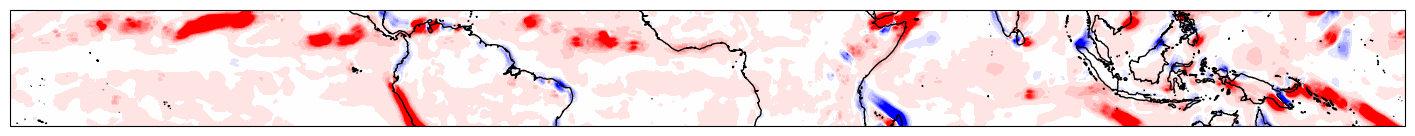

In [56]:
DR_map = LO.sel(pressure_level=1000,n_scales=0,valid_time='2016-08-09T03:00:00')
plt.figure(figsize=(18,3))
ax = plt.axes(projection=ccrs.PlateCarree())
lon = ds['longitude']
lat = ds['latitude']
ax.set_extent([180,-180,-15,15],crs=ccrs.PlateCarree())
plt.contourf(lon,lat,DR_map.T,cmap='bwr',levels=np.arange(-5e-3,5e-3,5e-4),extend='both')
ax.coastlines()

In [25]:
# Define the correct pressure level order
correct_order = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100]

# Function to correct pressure levels in a file
def correct_pressure_levels(file_path,output_dir):
    ds = xr.open_dataset(file_path)
    
    # Reorder pressure levels
    ds = ds.sel(pressure_level=correct_order)
    
    # Save the corrected file, overwrite the original file
    ds.to_netcdf(file_path)
    print(f"Corrected {file_path}")

# Path to your files
base_path = './'
output_dir = './'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through all the files from 20160801 to 20160909
start_date = datetime(2016, 8, 1)
end_date = datetime(2016, 9, 9)

# Generate all dates in the range
current_date = start_date
while current_date <= end_date:
    # Create input file name with date
    date_str = current_date.strftime('%Y%m%d')
    input_file_name = f"DRdir2dt_Nlmax5_era5_{date_str}.nc"
    input_file_path = os.path.join(base_path, input_file_name)
    
    # Define output file path
    output_file_path = os.path.join(output_dir, input_file_name)
    
    # Check if the input file exists
    if os.path.exists(input_file_path):
        correct_pressure_levels(input_file_path, output_file_path)
    else:
        print(f"File not found: {input_file_path}")
    
    # Move to the next day
    current_date += timedelta(days=1)

PermissionError: [Errno 13] Permission denied: '/home/users/emg97/emgScripts/LoSSETT/DRdir2dt_Nlmax5_era5_20160801.nc'

In [25]:
ds = xr.open_dataset('/gws/nopw/j04/kscale/USERS/emg/data/LoSSETT_out/ERA5_0p5deg_3h/DRdir2dt_Nlmax5_era5_20160909.nc')

# Assuming 'time' is the variable that contains time in hours from 0, 3, 6, ...
time_steps = ds['valid_time'].values
# # Define the starting date
start_date = pd.Timestamp('2016-09-01T00:00')

# Convert the time steps (1, 2, 3, ...) into hours by multiplying by 3
hours_since_start = (time_steps - 1) * 3  # Subtract 1 to make 1 -> 0h, 2 -> 3h, etc.
hours_since_start
# Create timestamps by adding the hours to the start date
time_in_timestamps = start_date + pd.to_timedelta(hours_since_start, unit='h')
time_in_timestamps
# Replace the time axis in the dataset
ds['valid_time'] = ('valid_time', time_in_timestamps)

# Save the modified dataset back to a new NetCDF file
output_file_path = '/gws/nopw/j04/kscale/USERS/emg/data/LoSSETT_out/ERA5_0p5deg_3h/DRdir2dt_Nlmax5_era5_20160909_MM.nc'
ds.to_netcdf(output_file_path)

In [ ]:
aug_u = xr.open_dataset('/gws/nopw/j04/kscale/USERS/dship/ERA5/era5_u_component_of_wind_201608_3h_0p5deg.nc')
sep_u = xr.open_dataset('/gws/nopw/j04/kscale/USERS/dship/ERA5/era5_u_component_of_wind_201609_3h_0p5deg.nc')

aug_v = xr.open_dataset('/gws/nopw/j04/kscale/USERS/dship/ERA5/era5_v_component_of_wind_201608_3h_0p5deg.nc')
sep_v = xr.open_dataset('/gws/nopw/j04/kscale/USERS/dship/ERA5/era5_v_component_of_wind_201609_3h_0p5deg.nc')

aug_w = xr.open_dataset('/gws/nopw/j04/kscale/USERS/dship/ERA5/era5_vertical_velocity_201608_3h_0p5deg.nc')
sep_w = xr.open_dataset('/gws/nopw/j04/kscale/USERS/dship/ERA5/era5_vertical_velocity_201609_3h_0p5deg.nc')
sep_w

In [22]:
if isinstance(aug_w.valid_time.dtype, np.dtype('int64')):
    aug_w['valid_time'] = pd.to_datetime(aug_w['valid_time'], unit='D', origin='unix')

if isinstance(sep_w.valid_time.dtype, np.dtype('int64')):
    sep_w['valid_time'] = pd.to_datetime(sep_w['valid_time'], unit='D', origin='unix')

# Concatenate datasets
combined_ds = xr.concat([aug_w, sep_w], dim='valid_time', join='outer')

TypeError: isinstance() arg 2 must be a type, a tuple of types, or a union